In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
#for below, you may need to do pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

In [2]:
 # Fetch the Breast Cancer Wisconsin dataset from UCI repository
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Get the features (X) and targets (y) as pandas DataFrames
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Print columns to verify the structure
print("Feature columns:\n", X.columns)
print("Target columns:\n", y.columns)

# metadata 
#print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
#print(breast_cancer_wisconsin_diagnostic.variables) 

Feature columns:
 Index(['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3'],
      dtype='object')
Target columns:
 Index(['Diagnosis'], dtype='object')


In [3]:
y = y.iloc[:, 0]  # extract the Series

# Map the diagnosis labels: 1 for malignant ('M'), 0 for benign ('B')
y = y.map({'M': 1, 'B': 0})  # Adjust this mapping as per the dataset's structure

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Separate the benign (malignant) examples for training the positive (negative) autoencoder
X_benign = X_scaled[y == 0]  # Benign examples
X_malignant = X_scaled[y == 1]  # Malignant examples

# Split benign data into train and test sets
X_train_benign, X_test_benign = train_test_split(X_benign, test_size=0.2, random_state=42)

# Split malignant data into train and test sets
X_train_malignant, X_test_malignant = train_test_split(X_malignant, test_size=0.2, random_state=42)

# combine the test sets
X_test = np.concatenate((X_test_benign, X_test_malignant), axis=0)
y_test = np.concatenate((np.zeros(len(X_test_benign)), np.ones(len(X_test_malignant))), axis=0)

In [5]:
# Define and train the positive autoencoder on benign data
autoencoder_pos = MLPRegressor(hidden_layer_sizes=(14, 7, 14), activation='relu', max_iter=200, random_state=42)
autoencoder_pos.fit(X_train_benign, X_train_benign)

# Define and train the negative autoencoder on malignant data
autoencoder_neg = MLPRegressor(hidden_layer_sizes=(14, 7, 14), activation='relu', max_iter=200, random_state=42)
autoencoder_neg.fit(X_train_malignant, X_train_malignant)

/Users/jason.bono/anaconda3/envs/minenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jason.bono/anaconda3/envs/minenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(14, 7, 14), random_state=42)

In [6]:
#get feature-level reconstruction errors for positive and negative autoencoder
X_test_pos = autoencoder_pos.predict(X_test)
X_test_neg = autoencoder_neg.predict(X_test)


# get the patient-level (ie point-level) reconstruction errors (ie the scores)
scores_pos = np.mean(np.power(X_test - X_test_pos, 2), axis=1)
scores_neg = np.mean(np.power(X_test - X_test_neg, 2), axis=1)


#combine the positive and negative scores
scores_dual = (scores_pos - scores_neg) / (scores_pos + scores_neg + 1e-8)  


In [7]:
# Calculate the ROC curve and AUC for the positive model
fpr_pos, tpr_pos, _ = roc_curve(y_test, scores_pos)
roc_auc_pos = auc(fpr_pos, tpr_pos)

# Calculate the ROC curve and AUC for the negative model
fpr_neg, tpr_neg, _ = roc_curve(y_test, scores_neg)
roc_auc_neg = auc(fpr_neg, tpr_neg)

# Calculate the ROC curve and AUC for the dual model
fpr_dual, tpr_dual, _ = roc_curve(y_test, scores_dual)
roc_auc_dual = auc(fpr_dual, tpr_dual)

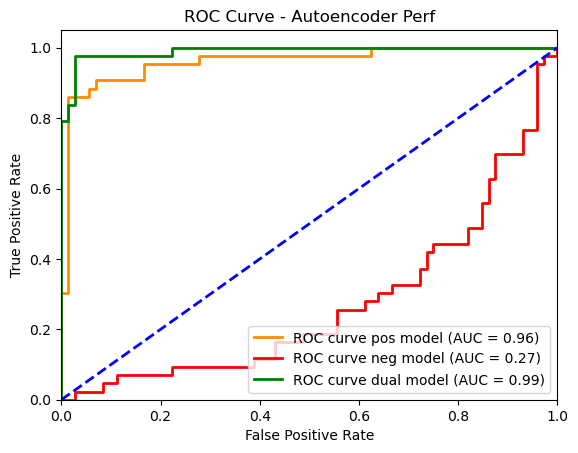

In [8]:


# Plot the ROC curve
plt.figure()
#add the positive roc curve
plt.plot(fpr_pos, tpr_pos, color='darkorange', lw=2, label=f'ROC curve pos model (AUC = {roc_auc_pos:.2f})')
#add the negative roc curve 
plt.plot(fpr_neg, tpr_neg, color='red', lw=2, label=f'ROC curve neg model (AUC = {roc_auc_neg:.2f})')
#add the dual roc curve
plt.plot(fpr_dual, tpr_dual, color='green', lw=2, label=f'ROC curve dual model (AUC = {roc_auc_dual:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Autoencoder Perf')
plt.legend(loc='lower right')
plt.show()

